In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [6]:
df=pd.read_csv("../../data/merged/len3_prod_mon_Q_DN.csv",encoding="shift-jis",index_col=0)
df["prod_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4194    2022-08-31
4195    2022-09-30
4196    2022-10-31
4197    2022-11-30
4198    2022-12-31
Name: prod_date, Length: 4199, dtype: object

Estimation

In [7]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4194    0
4195    0
4196    0
4197    0
4198    0
Name: mon_1, Length: 4199, dtype: uint8

In [8]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_pro_agg"].replace(",","",regex=True,inplace=True)
df["rx_pro_agg"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_pro_agg"].fillna(0,inplace=True)
df["rx_pro_agg"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_pro_agg"]=df["otc_pro_agg"].astype(int)
df["rx_pro_agg"]=df["rx_pro_agg"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(float)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_pro_agg"]>0]
df=df.loc[df["rx_pro_agg"]>0]
df=df.loc[df["stock_otc_lag"]>0]
df=df.loc[df["stock_rx_lag"]>0]

# make log columns
df["log_rx_pro_agg"]=np.log(df["rx_pro_agg"])
df["log_otc_pro_agg"]=np.log(df["otc_pro_agg"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

In [9]:
# change to the datetime format
df['prod_date'] = pd.to_datetime(df["prod_date"], format='%Y-%m-%d')
df=df.set_index(["id","prod_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2470 entries, (114, Timestamp('2009-02-28 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 269 entries, year to year_trend
dtypes: float64(18), int32(2), int64(221), object(16), uint8(12)
memory usage: 4.9+ MB


(269, 167, 19)

In [10]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

## RX

In [11]:
before_p=10*4
after_p=15*4
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)


+elapsed_m40+elapsed_m39+elapsed_m38+elapsed_m37+elapsed_m36+elapsed_m35+elapsed_m34+elapsed_m33+elapsed_m32+elapsed_m31+elapsed_m30+elapsed_m29+elapsed_m28+elapsed_m27+elapsed_m26+elapsed_m25+elapsed_m24+elapsed_m23+elapsed_m22+elapsed_m21+elapsed_m20+elapsed_m19+elapsed_m18+elapsed_m17+elapsed_m16+elapsed_m15+elapsed_m14+elapsed_m13+elapsed_m12+elapsed_m11+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+elapsed_21+elapsed_22+elapsed_23+elapsed_24+elapsed_25+elapsed_26+elapsed_27+elapsed_28+elapsed_29+elapsed_30+elapsed_31+elapsed_32+elapsed_33+elapsed_34+elapsed_35+elapsed_36+elapsed_37+elapsed_38+elapsed_39+elapsed_40+elapsed_41+elapsed_42+elapsed_43+elapsed_44+elapsed_45+elapsed_46+elapsed_47+elapsed_48+elapsed_49

                                Parameter Estimates                                 
                  Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------------
elapsed_m40         -0.1136     0.1441    -0.7883     0.4306     -0.3962      0.1690
elapsed_m39         -0.2467     0.1507    -1.6368     0.1018     -0.5423      0.0489
elapsed_m38         -0.3781     0.2843    -1.3302     0.1836     -0.9356      0.1793
elapsed_m37         -0.1010     0.1224    -0.8253     0.4093     -0.3410      0.1390
elapsed_m36         -0.2011     0.1191    -1.6889     0.0914     -0.4346      0.0324
elapsed_m35         -0.1592     0.1230    -1.2948     0.1955     -0.4003      0.0819
elapsed_m34         -0.1546     0.1372    -1.1269     0.2599     -0.4237      0.1145
elapsed_m33         -0.2138     0.1214    -1.7605     0.0785     -0.4519      0.0244
elapsed_m32         -0.0775     0.1410    -0.5497     0.5826     

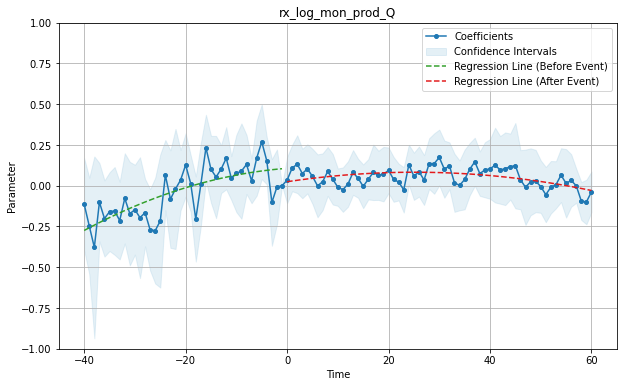

In [12]:
# take log
formula="log_rx_pro_agg ~ "+elapsed


# log_stock_rx_lag
formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_prod_Q",title="rx_log_mon_prod_Q",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
elapsed_m40           0.4683     0.2931     1.5974     0.1103     -0.1066      1.0431
elapsed_m39          -0.1480     0.5392    -0.2744     0.7838     -1.2054      0.9095
elapsed_m38           0.6520     0.4076     1.5995     0.1099     -0.1474      1.4514
elapsed_m37           0.5624     0.3308     1.6999     0.0893     -0.0864      1.2112
elapsed_m36           0.8782     0.4922     1.7843     0.0745     -0.0870      1.8434
elapsed_m35           0.4937     0.3272     1.5090     0.1315     -0.1479      1.1354
elapsed_m34           0.2388     0.3906     0.6113     0.5411     -0.5273      1.0049
elapsed_m33           0.3345     0.5276     0.6339     0.5262     -0.7003      1.3692
elapsed_m32           0.8240     0.3774     2.1834    

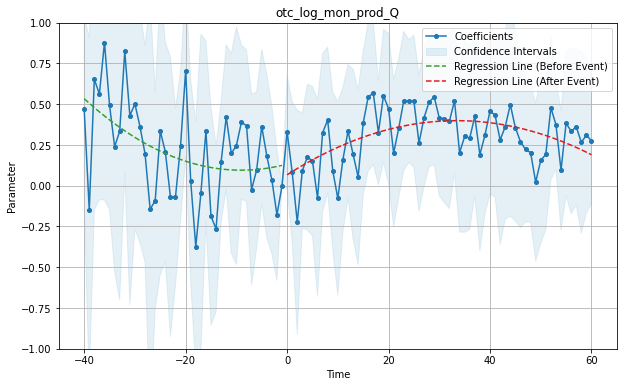

In [13]:
# take log

# till 20
# formula="log_otc_pro_agg ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_pro_agg ~ "+elapsed


# log_stock_otc_lag
formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
formula+=" + generic_share_r"
# generic_share_q
formula+=" + generic_share_q"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_prod_Q",title="otc_log_mon_prod_Q",ylim=(-1,1),plot_type="o-",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

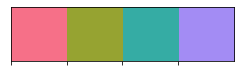

In [14]:
import seaborn as sns

# 視認性の良い4つの色を生成
colors = sns.color_palette('husl', 4)

# カラーマップを表示
sns.palplot(colors)
